# Problem Definition
Source: [Kaggle - Flight Delay Prediction](https://www.kaggle.com/divyansh22/flight-delay-prediction)

<img src="misc/kaggle_flight_delay_prediction.png" width=90%/>

In [1]:
from swat import CAS
import numpy as np
import seaborn as sn

In [2]:
s = CAS(hostname='localhost', port=5570, username='sas', password='saspw')
s.setsessopt(messagelevel='NONE')

+ Elapsed: 0.000262s, user: 0.000184s, mem: 0.256mb

## Read local data

In [3]:
column_names = ['OP_CARRIER',        # Code assigned by IATA and commonly used to identify a carrier.
                'OP_CARRIER_FL_NUM', # Flight number
                'ORIGIN',            # Origin
                'DEST',              # Destination
                'DAY_OF_MONTH',      # Day of month
                'DAY_OF_WEEK',       # Day of week
                'DEP_TIME',          # Departure Time
                'ARR_TIME',          # Arrival Time
                'DISTANCE',          # Flight Distance
                'CANCELLED',         # Cancel Indicator (Binary)
                'DIVERTED',          # DIVERTED Indicator (Binary)
                'ARR_DEL15',         # Delay Indicator (Binary)
                'YEAR']              # Year (will be used for partitioning)

data_types = {'OP_CARRIER_FL_NUM': str, 
              'ORIGIN':            str, 
              'DEST':              str, 
              'CANCELLED':         str, 
              'DIVERTED':          str, 
              'ARR_DEL15':         str}

flight_data = s.read_csv(filepath_or_buffer = 'data/flights_january_2019.csv', 
                         usecols            = column_names, 
                         dtype              = data_types, 
                         casout             = dict(name='flight_data', replace=True))[column_names]

In [4]:
flight_data.tableinfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,FLIGHT_DATA,100001,13,0,utf-8,2021-03-03T09:18:20+00:00,2021-03-03T09:18:20+00:00,2021-03-03T09:18:20+00:00,UTF8,1.930382e+09,...,0,0,0,,,0,sas,,2021-03-03T09:18:20+00:00,1.930382e+09


In [5]:
flight_data.columninfo()

,Column,Label,ID,Type,RawLength,FormattedLength,Format,NFL,NFD
0,OP_CARRIER,,3,varchar,2,2,,0,0
1,OP_CARRIER_FL_NUM,,4,varchar,4,4,,0,0
2,ORIGIN,,5,varchar,3,3,,0,0
3,DEST,,6,varchar,3,3,,0,0
4,DAY_OF_MONTH,,1,double,8,12,,0,0
5,DAY_OF_WEEK,,2,double,8,12,,0,0
6,DEP_TIME,,7,double,8,12,,0,0
7,ARR_TIME,,8,double,8,12,,0,0
8,DISTANCE,,12,double,8,12,,0,0
9,CANCELLED,,10,varchar,4,4,,0,0


In [6]:
flight_data.head()

,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME,ARR_TIME,DISTANCE,CANCELLED,DIVERTED,ARR_DEL15,YEAR
0,DL,2777,SFO,LAX,21.0,1.0,717.0,858.0,337.0,0.00,0.00,0.00,2019.0
1,AA,969,LAS,JFK,28.0,1.0,1123.0,1910.0,2248.0,0.00,0.00,0.00,2019.0
2,NK,570,TPA,MSY,1.0,2.0,1110.0,1147.0,488.0,0.00,0.00,0.00,2019.0
3,OO,3117,MKE,ORD,11.0,5.0,500.0,546.0,67.0,0.00,0.00,0.00,2019.0
4,DL,1790,ICT,ATL,24.0,4.0,1115.0,1407.0,782.0,0.00,0.00,0.00,2019.0


In [7]:
numeric_variables = flight_data.select_dtypes('numeric').columns.to_list()
numeric_variables.remove('YEAR') # Remove partition variable
categorical_variables = flight_data.select_dtypes('character').columns.to_list()

print("\nNumeric Variables:\n{}\n".format(numeric_variables))
print("\nCategorical Variables:\n{}".format(categorical_variables))


Numeric Variables:
['DAY_OF_MONTH', 'DAY_OF_WEEK', 'DEP_TIME', 'ARR_TIME', 'DISTANCE']


Categorical Variables:
['OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'CANCELLED', 'DIVERTED', 'ARR_DEL15']


## Simple Statistics & Plotting

In [8]:
s.help()

,name,description
0,accessPersonalCaslibs,Provides administrative access to all personal...
1,assumeRole,Assumes a role
2,dropRole,Relinquishes a role
3,showRolesIn,Shows the currently active role
4,showRolesAllowed,Shows the roles that a user is a member of
5,isInRole,Shows whether a role is assumed
6,isAuthorized,Shows whether access is authorized
7,isAuthorizedActions,Shows whether access is authorized to actions
8,isAuthorizedTables,Shows whether access is authorized to tables
9,isAuthorizedColumns,Shows whether access is authorized to columns


In [9]:
s.simple?

Signature:   s.simple(*args, **kwargs)
Type:        Simple
String form: <swat.cas.actions.Simple object at 0x7f7a947dbf50>
File:        /opt/conda/envs/python_sas/lib/python3.7/site-packages/swat/cas/actions.py
Docstring:  
Simple Analytics

Actions
-------
simple.compare     : Compares two tables by computing the index and frequency of
                     each group, cumulative frequency, and the index of each
                     record within its group
simple.correlation : Computes Pearson product-moment correlations.
simple.crosstab    : Performs one-way or two-way tabulations
simple.distinct    : Computes the distinct number of values of the variables in
                     the variable list
simple.freq        : Generates a frequency distribution for one or more
                     variables
simple.groupby     : Builds BY groups in terms of the variable value
                     combinations given the variables in the variable list
simple.groupbyinfo : Computes the index and f

### Simple descriptive statistics

In [10]:
flight_data.simple.summary(inputs=numeric_variables)

,Column,Min,Max,N,NMiss,Mean,Sum,Std,StdErr,Var,USS,CSS,CV,TValue,ProbT,Skewness,Kurtosis
0,DAY_OF_MONTH,1.0,31.0,100001.0,0.0,15.930301,1593046.0,9.002365,0.028468,81.042582,3.348196e+07,8.104258e+06,56.510957,559.589440,0.0,0.018247,-1.210631
1,DAY_OF_WEEK,1.0,7.0,100001.0,0.0,3.824822,382486.0,1.923999,0.006084,3.701772,1.833118e+06,3.701772e+05,50.302972,628.649425,0.0,0.169118,-1.102811
2,DEP_TIME,1.0,2400.0,97235.0,2766.0,1333.174783,129631250.0,493.827465,1.583667,243865.565199,1.965331e+11,2.371202e+10,37.041465,841.827598,0.0,0.020034,-0.992717
3,ARR_TIME,1.0,2400.0,97114.0,2887.0,1485.806773,144292639.0,522.194807,1.675682,272687.416320,2.408725e+11,2.648149e+10,35.145540,886.687746,0.0,-0.362424,-0.360125
4,DISTANCE,31.0,4983.0,100001.0,0.0,797.506205,79751418.0,589.694973,1.864770,347740.160904,9.837627e+10,3.477402e+10,73.942368,427.670030,0.0,1.453959,2.355568


### Frequency distribution for variables

In [11]:
frequency_by_carrier = flight_data.simple.freq(inputs='OP_CARRIER')['Frequency']
frequency_by_carrier

,Column,CharVar,FmtVar,Level,Frequency
0,OP_CARRIER,9E,9E,1,3459.0
1,OP_CARRIER,AA,AA,2,13188.0
2,OP_CARRIER,AS,AS,3,3552.0
3,OP_CARRIER,B6,B6,4,4186.0
4,OP_CARRIER,DL,DL,5,12643.0
5,OP_CARRIER,EV,EV,6,2259.0
6,OP_CARRIER,F9,F9,7,1652.0
7,OP_CARRIER,G4,G4,8,1158.0
8,OP_CARRIER,HA,HA,9,1164.0
9,OP_CARRIER,MQ,MQ,10,4401.0


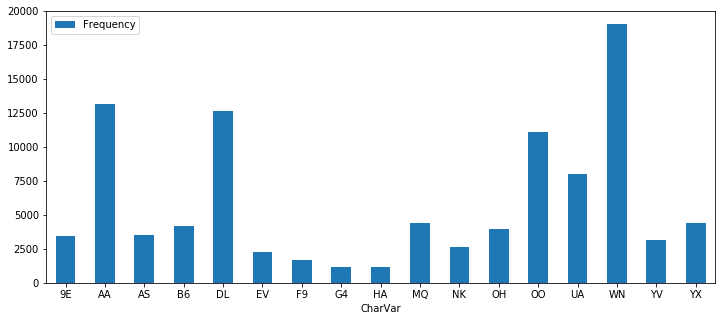

In [12]:
frequency_by_carrier.plot.bar(x='CharVar', y='Frequency', figsize=(12,5), rot=0)

In [43]:
flight_data.simple.freq(inputs=['ARR_DEL15','OP_CARRIER'])

,Column,CharVar,FmtVar,Level,Frequency
0,ARR_DEL15,,,1,3040.0
1,ARR_DEL15,0.00,0.00,2,79017.0
2,ARR_DEL15,1.00,1.00,3,17944.0
3,OP_CARRIER,9E,9E,1,3459.0
4,OP_CARRIER,AA,AA,2,13188.0
5,OP_CARRIER,AS,AS,3,3552.0
6,OP_CARRIER,B6,B6,4,4186.0
7,OP_CARRIER,DL,DL,5,12643.0
8,OP_CARRIER,EV,EV,6,2259.0
9,OP_CARRIER,F9,F9,7,1652.0


In [89]:
flight_data.simple.mdsummary(inputs=['ARR_DEL15'])

+ Elapsed: 0.000451s, user: 0.000361s, sys: 1.2e-05s, mem: 0.465mb

In [98]:
flight_data.simple.crosstab(row='OP_CARRIER', aggregator='sum', includeMissing=False, col='ARR_DEL15')

,OP_CARRIER,Col1,Col2
0,9E,2708.0,691.0
1,AA,10573.0,2328.0
2,AS,2872.0,586.0
3,B6,2871.0,1124.0
4,DL,10995.0,1583.0
5,EV,1551.0,540.0
6,F9,1229.0,397.0
7,G4,891.0,256.0
8,HA,1024.0,137.0
9,MQ,3066.0,983.0


In [65]:
x = flight_data.simple.groupby(aggregator='sum', inputs=['OP_CARRIER','ARR_DEL15'], includemissing=False)

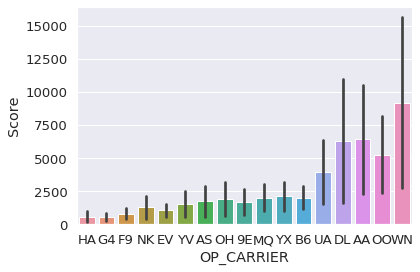

In [77]:
sn.barplot(x='OP_CARRIER', y='Score', data=x['Groupby'])

In [84]:
x['Groupby']

,OP_CARRIER,OP_CARRIER_f,ARR_DEL15,ARR_DEL15_f,Rank,Score
0,HA,HA,1.00,1.00,34,137.0
1,G4,G4,1.00,1.00,33,256.0
2,F9,F9,1.00,1.00,32,397.0
3,NK,NK,1.00,1.00,31,407.0
4,EV,EV,1.00,1.00,30,540.0
5,YV,YV,1.00,1.00,29,576.0
6,AS,AS,1.00,1.00,28,586.0
7,OH,OH,1.00,1.00,27,620.0
8,9E,9E,1.00,1.00,26,691.0
9,G4,G4,0.00,0.00,25,891.0


In [76]:
x['Groupby']

,OP_CARRIER,OP_CARRIER_f,ARR_DEL15,ARR_DEL15_f,Rank,Score
0,HA,HA,1.00,1.00,34,137.0
1,G4,G4,1.00,1.00,33,256.0
2,F9,F9,1.00,1.00,32,397.0
3,NK,NK,1.00,1.00,31,407.0
4,EV,EV,1.00,1.00,30,540.0
5,YV,YV,1.00,1.00,29,576.0
6,AS,AS,1.00,1.00,28,586.0
7,OH,OH,1.00,1.00,27,620.0
8,9E,9E,1.00,1.00,26,691.0
9,G4,G4,0.00,0.00,25,891.0


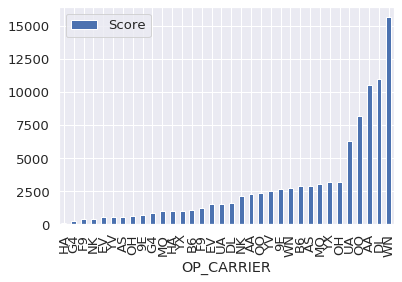

In [73]:
x['Groupby'].plot.bar(x='OP_CARRIER', y='Score', stacked=True)

In [46]:
import pandas as pd

In [57]:
column_names = ['OP_CARRIER',        # Code assigned by IATA and commonly used to identify a carrier.
                'OP_CARRIER_FL_NUM', # Flight number
                'ORIGIN',            # Origin
                'DEST',              # Destination
                'DAY_OF_MONTH',      # Day of month
                'DAY_OF_WEEK',       # Day of week
                'DEP_TIME',          # Departure Time
                'ARR_TIME',          # Arrival Time
                'DISTANCE',          # Flight Distance
                'CANCELLED',         # Cancel Indicator (Binary)
                'DIVERTED',          # DIVERTED Indicator (Binary)
                'ARR_DEL15',         # Delay Indicator (Binary)
                'YEAR']              # Year (will be used for partitioning)

data_types = {'OP_CARRIER_FL_NUM': str, 
              'ORIGIN':            str, 
              'DEST':              str, 
              'CANCELLED':         str, 
              'DIVERTED':          str, 
              'ARR_DEL15':         float}

f = pd.read_csv('data/flights_january_2019.csv', usecols=column_names, dtype=data_types)

In [58]:
f.dtypes

DAY_OF_MONTH           int64
DAY_OF_WEEK            int64
OP_CARRIER            object
OP_CARRIER_FL_NUM     object
ORIGIN                object
DEST                  object
DEP_TIME             float64
ARR_TIME             float64
ARR_DEL15            float64
CANCELLED             object
DIVERTED              object
DISTANCE             float64
YEAR                   int64
dtype: object

In [60]:
f.groupby('OP_CARRIER').agg('sum')

,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME,ARR_TIME,ARR_DEL15,DISTANCE,YEAR
OP_CARRIER,,,,,,,
9E,56316,12742,4560350.0,5039298.0,691.0,1607104.0,6983721
AA,211416,50696,17126894.0,19205889.0,2328.0,12966965.0,26626572
AS,55381,13426,4598158.0,5178463.0,586.0,4673603.0,7171488
B6,66131,16193,5470852.0,5636356.0,1124.0,4671960.0,8451534
DL,206122,47636,16794020.0,18875259.0,1583.0,11405570.0,25526217
EV,35124,8809,2793467.0,3094998.0,540.0,1025505.0,4560921
F9,26644,6533,2133321.0,2357986.0,397.0,1774049.0,3335388
G4,17280,4935,1460513.0,1708371.0,256.0,1061466.0,2338002
HA,18575,4556,1497493.0,1657818.0,137.0,808811.0,2350116


In [48]:
column_names = ['OP_CARRIER',        # Code assigned by IATA and commonly used to identify a carrier.
                'OP_CARRIER_FL_NUM', # Flight number
                'ORIGIN',            # Origin
                'DEST',              # Destination
                'DAY_OF_MONTH',      # Day of month
                'DAY_OF_WEEK',       # Day of week
                'DEP_TIME',          # Departure Time
                'ARR_TIME',          # Arrival Time
                'DISTANCE',          # Flight Distance
                'CANCELLED',         # Cancel Indicator (Binary)
                'DIVERTED',          # DIVERTED Indicator (Binary)
                'ARR_DEL15',         # Delay Indicator (Binary)
                'YEAR']              # Year (will be used for partitioning)

data_types = {'OP_CARRIER_FL_NUM': str, 
              'ORIGIN':            str, 
              'DEST':              str, 
              'CANCELLED':         str, 
              'DIVERTED':          str, 
              'ARR_DEL15':         str}

flight_data = s.read_csv(filepath_or_buffer = 'data/flights_january_2019.csv', 
                         usecols            = column_names, 
                         dtype              = data_types, 
                         casout             = dict(name='flight_data', replace=True))[column_names]

,Unnamed: 0,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_TIME,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,YEAR
0,0,8,2,WN,1842,SAN,SFO,1007.0,1133.0,0.0,0.0,0.0,447.0,2019
1,1,10,4,WN,1217,ATL,TPA,1927.0,2050.0,0.0,0.0,0.0,406.0,2019
2,2,16,3,EV,4238,ORD,COU,1936.0,2100.0,0.0,0.0,0.0,315.0,2019
3,3,27,7,WN,5533,MCO,STL,1212.0,1339.0,0.0,0.0,0.0,882.0,2019
4,4,22,2,B6,589,DCA,JAX,1619.0,1814.0,1.0,0.0,0.0,634.0,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,99996,14,1,EV,4001,CLE,LGA,837.0,1111.0,1.0,0.0,0.0,419.0,2019
99997,99997,13,7,WN,5190,LAS,PHX,1308.0,1518.0,0.0,0.0,0.0,255.0,2019
99998,99998,3,4,WN,2006,STL,LAX,557.0,750.0,0.0,0.0,0.0,1592.0,2019
99999,99999,26,6,MQ,3499,CMH,LGA,943.0,1203.0,1.0,0.0,0.0,479.0,2019


### Correlation of numerical variables

In [13]:
pearson_correlation = flight_data.simple.correlation(inputs=numeric_variables)
pearson_correlation

[CorrSimple]

 Summary Statistics in Correlation Analysis for FLIGHT_DATA
 
        Variable         N         Mean          Sum      StdDev  Minimum  \
 0  DAY_OF_MONTH  100001.0    15.930301    1593046.0    9.002365      1.0   
 1   DAY_OF_WEEK  100001.0     3.824822     382486.0    1.923999      1.0   
 2      DEP_TIME   97235.0  1333.174783  129631250.0  493.827465      1.0   
 3      ARR_TIME   97114.0  1485.806773  144292639.0  522.194807      1.0   
 4      DISTANCE  100001.0   797.506205   79751418.0  589.694973     31.0   
 
    Maximum  
 0     31.0  
 1      7.0  
 2   2400.0  
 3   2400.0  
 4   4983.0  

[Correlation]

 Pearson Correlation Coefficients for FLIGHT_DATA
 
        Variable  DAY_OF_MONTH  DAY_OF_WEEK  DEP_TIME  ARR_TIME  DISTANCE  \
 0  DAY_OF_MONTH      1.000000    -0.032453 -0.003032  0.002488 -0.020042   
 1   DAY_OF_WEEK     -0.032453     1.000000  0.001822  0.004689  0.018639   
 2      DEP_TIME     -0.003032     0.001822  1.000000  0.670030 -0.024040   
 3      ARR_TIME      0.002488     0.004689  0.670030  1.000000  0.025198   
 4      DISTANCE     -0.020042     0.018639 -0.024040  0.025198  1.000000   
 
       Nobs1     Nobs2    Nobs3    Nobs4     Nobs5  
 0  100001.0  100001.0  97235.0  97114.0  100001.0  
 1  100001.0  100001.0  97235.0  97114.0  100001.0  
 2   97235.0   97235.0  97235.0  97114.0   97235.0  
 3   97114.0   97114.0  97114.0  97114.0   97114.0  
 4  100001.0  100001.0  97235.0  97114.0  100001.0  

+ Elapsed: 0.177s, user: 0.0831s, sys: 0.0482s, mem: 2.52mb

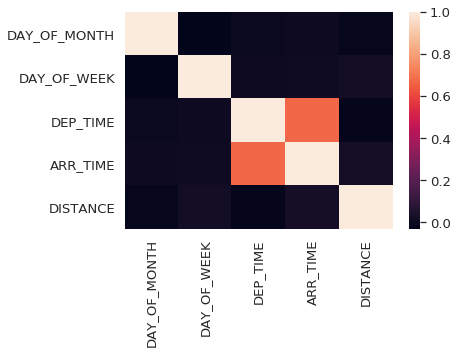

In [14]:
# SAS mirrors a lot of the Pandas-functionality
pearson_correlation = flight_data[numeric_variables].corr()
# Visualize with open source libraries
sn.set(font_scale=1.2)
sn.heatmap(pearson_correlation)

### SAS mirrors a lot of the pandas API functionality

In [15]:
type(flight_data) # flight_data is a CAS-table

swat.cas.table.CASTable

In [16]:
# Pandas: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html
# SAS: https://sassoftware.github.io/python-swat/generated/swat.cas.table.CASTable.describe.html
flight_data.describe(include='all')

,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME,ARR_TIME,DISTANCE,CANCELLED,DIVERTED,ARR_DEL15,YEAR
count,100001,100001,100001,100001,100001,100001,97235,97114,100001,100001,100001,96961,100001
unique,17,6451,343,344,31,7,1344,1418,1434,2,2,2,1
top,WN,345,ATL,ATL,2,4,555,1600,337,0.00,0.00,0.00,2019
freq,19061,58,5302,5310,3521,16854,240,133,654,97171,99791,79017,100001
mean,NaN,NaN,NaN,NaN,15.9303,3.82482,1333.17,1485.81,797.506,NaN,NaN,NaN,2019
std,NaN,NaN,NaN,NaN,9.00237,1.924,493.827,522.195,589.695,NaN,NaN,NaN,0
min,9E,1,ABE,ABE,1,1,1,1,31,0.00,0.00,0.00,2019
25%,NaN,NaN,NaN,NaN,8,2,923,1105,361,NaN,NaN,NaN,2019
50%,NaN,NaN,NaN,NaN,16,4,1328,1517,640,NaN,NaN,NaN,2019
75%,NaN,NaN,NaN,NaN,24,5,1739,1919,1041,NaN,NaN,NaN,2019


In [17]:
# Pandas: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html
# SAS: https://sassoftware.github.io/python-swat/generated/swat.cas.table.CASTable.sample.html
flight_data.sample(n=3).head()

,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME,ARR_TIME,DISTANCE,CANCELLED,DIVERTED,ARR_DEL15,YEAR
0,UA,2224,LAX,EWR,29.0,2.0,2103.0,454.0,2454.0,0.00,0.00,0.00,2019.0
1,WN,1526,SAN,OAK,4.0,5.0,1721.0,1839.0,446.0,0.00,0.00,0.00,2019.0
2,MQ,3319,ORD,CMH,27.0,7.0,1600.0,1817.0,296.0,0.00,0.00,0.00,2019.0


## Modelling

#### Data Preparation
1. We remove missing values
2. We load data from 2020
3. We combine data from 2019 and 2020
4. We train our models on data from 2019 and evaluate its performance on data from 2020

In [18]:
# Remove missing values and create partition variable
flight_data_cleaned = flight_data.dropna()
print('\nDropped {} rows containing missing values from 2019 data.\n'.format(len(flight_data)-len(flight_data_cleaned)))
flight_data_cleaned.head()


Dropped 3040 rows containing missing values from 2019 data.



,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME,ARR_TIME,DISTANCE,CANCELLED,DIVERTED,ARR_DEL15,YEAR
0,WN,1290,MSP,MDW,17.0,4.0,2108.0,2229.0,349.0,0.00,0.00,0.00,2019.0
1,UA,2143,CLE,EWR,11.0,5.0,549.0,710.0,404.0,0.00,0.00,0.00,2019.0
2,DL,1386,MEM,LAX,18.0,5.0,558.0,811.0,1619.0,0.00,0.00,0.00,2019.0
3,AA,2048,PHX,SMF,14.0,1.0,2154.0,2248.0,647.0,0.00,0.00,0.00,2019.0
4,WN,2267,PWM,BWI,25.0,5.0,1054.0,1231.0,452.0,0.00,0.00,0.00,2019.0


In [19]:
# Load and clean test data
flight_data_test = s.read_csv('data/flights_january_2020.csv', 
                              usecols=column_names, 
                              dtype=data_types, 
                              casout=dict(name='flight_data_test', replace=True))[column_names]
flight_data_test_cleaned = flight_data_test.dropna()
print('\nDropped {} rows containing missing values from 2020 data.\n'.format(len(flight_data_test)-len(flight_data_test_cleaned)))
flight_data_test_cleaned.head()


Dropped 1334 rows containing missing values from 2020 data.



,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME,ARR_TIME,DISTANCE,CANCELLED,DIVERTED,ARR_DEL15,YEAR
0,DL,3048,DTW,GRR,27.0,1.0,2037.0,2125.0,120.0,0.00,0.00,0.00,2020.0
1,AA,375,JAX,DFW,26.0,7.0,715.0,904.0,918.0,0.00,0.00,0.00,2020.0
2,OO,5353,IAH,MKE,22.0,3.0,1822.0,2049.0,984.0,0.00,0.00,0.00,2020.0
3,UA,400,IAD,RDU,7.0,2.0,1817.0,1947.0,224.0,0.00,0.00,1.00,2020.0
4,WN,3946,BUR,SJC,18.0,6.0,1652.0,1752.0,296.0,0.00,0.00,0.00,2020.0


In [20]:
# Combine data from 2019 and 2020
flight_data_cleaned_2019_2020 = flight_data_cleaned.append(flight_data_test_cleaned)
flight_data_cleaned_2019_2020.head()

,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME,ARR_TIME,DISTANCE,CANCELLED,DIVERTED,ARR_DEL15,YEAR
0,OH,5186,CAE,CLT,31.0,5.0,521.0,607.0,88.0,0.00,0.00,0.00,2020.0
1,WN,190,SAN,LAS,16.0,4.0,1842.0,1958.0,258.0,0.00,0.00,0.00,2020.0
2,WN,857,BHM,MDW,3.0,5.0,1855.0,2027.0,570.0,0.00,0.00,0.00,2020.0
3,MQ,4117,HOU,DFW,19.0,7.0,1024.0,1133.0,247.0,0.00,0.00,0.00,2020.0
4,DL,1754,LGA,MIA,29.0,3.0,1310.0,1606.0,1096.0,0.00,0.00,0.00,2020.0


### Logistic Regression
https://documentation.sas.com/?cdcId=pgmsascdc&cdcVersion=9.4_3.5&docsetId=casactstat&docsetTarget=cas-regression-logistic.htm&locale=en#PYTHON.cas-regression-logistic-partfit

In [21]:
s.loadactionset('regression')

[actionset]

 'regression'

+ Elapsed: 0.0112s, sys: 0.00343s, mem: 0.224mb

In [22]:
inputs = ['DAY_OF_MONTH',
          'DAY_OF_WEEK',
          'DEP_TIME',
          'DISTANCE',
          'OP_CARRIER']

nominals = ['DAY_OF_MONTH',
            'DAY_OF_WEEK',
            'OP_CARRIER',
            'ARR_DEL15']

target = 'ARR_DEL15'

In [23]:
s.regression.logistic(
    table             = flight_data_cleaned_2019_2020,                        # input table
    inputs            = inputs,                                               # input variables
    nominals          = nominals,                                             # nominal variables
    target            = target,                                               # target variable
    selection         = dict(method='STEPWISE'),                              # Variable selection
    partbyvar         = dict(name='YEAR', train='2019', validate='2020'),     # partition by YEAR variable
    partfit           = True,                                                 # fit-statistics for partitioned data
    display           = dict(names=['ModelInfo','FitStatistics']),            # display ModelInfo and Fit statistics
    store             = dict(name='logreg_model', replace=True)               # table to store regression model
)

[ModelInfo]

 Model Information
 
          RowId             Description  \
 0         DATA             Data Source   
 1  RESPONSEVAR       Response Variable   
 2         DIST            Distribution   
 3         LINK           Link Function   
 4         TECH  Optimization Technique   
 
                                         Value  
 0  _PY_T_8B5B0D62_A47E_4CF2_9107_2A9E4E3EE676  
 1                                   ARR_DEL15  
 2                                      Binary  
 3                                       Logit  
 4                 Newton-Raphson with Ridging  

[SelectedModel.FitStatistics]

 Fit Statistics
 
        RowId                Description      Training    Validation
 0       M2LL          -2 Log Likelihood  87953.927523  81210.922420
 1        AIC    AIC (smaller is better)  88051.927523  81308.922420
 2       AICC   AICC (smaller is better)  88051.978085  81308.972108
 3        SBC    SBC (smaller is better)  88516.548665  81774.397709
 4        ASE       Average Square Error      0.142854      0.123490
 5   M2LLNULL  -2 Log L (Intercept-only)  92885.956431  79035.161679
 6    RSQUARE                   R-Square      0.049594           NaN
 7     ADJRSQ      Max-rescaled R-Square      0.080467           NaN
 8   MCFADDEN        McFadden's R-Square      0.053098           NaN
 9   MISCLASS     Misclassification Rate      0.184775      0.139258
 10  DIFFMEAN        Difference of Means      0.052672      0.021961

+ Elapsed: 3.53s, user: 27.6s, sys: 0.0612s, mem: 74.7mb

In [24]:
s.regression.logisticscore(
    restore                 = 'logreg_model', 
    table                   = flight_data_cleaned, 
    casout                  = dict(name='logreg_scored', replace=True),
    copyVars                = 'ALL'
)

,casLib,Name,Label,Rows,Columns,casTable
0,CASUSER(sas),logreg_scored,,96961,14,"CASTable('logreg_scored', caslib='CASUSER(sas)')"


In [25]:
s.CASTable('logreg_scored').head(5)

,_PRED_,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_TIME,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,YEAR
0,0.863890,5.0,6.0,UA,470,MCO,SFO,843.0,1145.0,0.00,0.00,0.00,2446.0,2019.0
1,0.707620,28.0,1.0,MQ,4197,ORD,CID,1842.0,1950.0,1.00,0.00,0.00,196.0,2019.0
2,0.906587,27.0,7.0,WN,5212,ATL,LAS,653.0,815.0,0.00,0.00,0.00,1747.0,2019.0
3,0.830131,26.0,6.0,OO,7367,APN,DTW,1354.0,1510.0,0.00,0.00,0.00,198.0,2019.0
4,0.860179,22.0,2.0,WN,2062,AUS,LAX,950.0,1100.0,0.00,0.00,0.00,1242.0,2019.0


### Gradient Boosting
https://documentation.sas.com/?cdcId=pgmsascdc&cdcVersion=9.4_3.5&docsetId=casanpg&docsetTarget=cas-decisiontree-gbtreetrain.htm&locale=en#SAS.cas-decisiontree-gbtreetrain-nominals

In [26]:
s.loadactionset('decisiontree')
s.help(actionset='decisiontree')

,name,description
0,dtreeTrain,Trains a decision tree
1,dtreeScore,Scores a table using a decision tree model
2,dtreeSplit,Splits decision tree nodes
3,dtreePrune,Prune a decision tree
4,dtreeMerge,Merges decision tree nodes
5,dtreeCode,Generates DATA step scoring code from a decisi...
6,forestTrain,Trains a forest. This action requires a SAS Vi...
7,forestScore,Scores a table using a forest model
8,forestCode,Generates DATA step scoring code from a forest...
9,gbtreeTrain,Trains a gradient boosting tree. This action r...


In [27]:
s.decisiontree.gbtreetrain(
    table             = flight_data_cleaned,                      # input table
    inputs            = inputs,                                   # input variables
    nominals          = nominals,                                 # nominal variables
    target            = target,                                   # target variable
    validtable        = flight_data_test_cleaned,                 # validation table
    ntree             = 10,                                       # Number of trees
    maxlevel          = 3,                                        # Maximum tree depth
    casOut            = dict(name='gbtree_model', replace=True)   # table to store boosting model
)

,Descr,Value
0,Number of Trees,10.0
1,Distribution,2.0
2,Learning Rate,0.1
3,Subsampling Rate,0.5
4,Number of Selected Variables (M),5.0
5,Number of Bins,50.0
6,Number of Variables,5.0
7,Max Number of Tree Nodes,7.0
8,Min Number of Tree Nodes,7.0
9,Max Number of Branches,2.0


In [28]:
s.decisiontree.gbtreescore(
    modeltable              = 'gbtree_model', 
    table                   = flight_data_test_cleaned,
    casOut                  = dict(name='gbtree_scored', replace=True),
    copyVars                = list(flight_data_test_cleaned.columns)
)

[OutputCasTables]

          casLib           Name   Rows  Columns  \
 0  CASUSER(sas)  gbtree_scored  98666       17   
 
                                            casTable  
 0  CASTable('gbtree_scored', caslib='CASUSER(sas)')  

[ScoreInfo]

                          Descr                             Value
 0  Number of Observations Read                             98666
 1  Number of Observations Used                             98666
 2  Misclassification Error (%)                      13.756511868

[ErrorMetricInfo]

    TreeID  Trees  NLeaves       MCR   LogLoss       ASE      RASE     MAXAE
 0     0.0    1.0      4.0  0.137565  0.407695  0.120641  0.347334  0.823427
 1     1.0    2.0      8.0  0.137565  0.406575  0.120321  0.346873  0.832745
 2     2.0    3.0     12.0  0.137565  0.406085  0.120204  0.346704  0.840127
 3     3.0    4.0     16.0  0.137565  0.405775  0.120147  0.346622  0.846043
 4     4.0    5.0     20.0  0.137565  0.405537  0.120118  0.346581  0.852913
 5     5.0    6.0     24.0  0.137565  0.405503  0.120146  0.346620  0.856937
 6     6.0    7.0     28.0  0.137565  0.405473  0.120175  0.346663  0.862609
 7     7.0    8.0     32.0  0.137565  0.405534  0.120250  0.346771  0.868301
 8     8.0    9.0     36.0  0.137565  0.405517  0.120290  0.346828  0.870942
 9     9.0   10.0     40.0  0.137565  0.405955  0.120467  0.347084  0.875416

+ Elapsed: 0.159s, user: 1.28s, sys: 0.0159s, mem: 42.1mb

In [31]:
s.CASTable('gbtree_scored').head(5)

,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME,ARR_TIME,DISTANCE,CANCELLED,DIVERTED,ARR_DEL15,YEAR,_GBT_PredName_,_GBT_PredP_,_GBT_PredLevel_,_MissIt_
0,DL,2737,JFK,LAS,8.0,3.0,1846.0,2150.0,2248.0,0.00,0.00,0.00,2020.0,0.00,0.825618,0.0,0.0
1,NK,657,FLL,MSY,7.0,2.0,709.0,806.0,674.0,0.00,0.00,0.00,2020.0,0.00,0.864813,0.0,0.0
2,AA,1579,FLL,DFW,11.0,6.0,1621.0,1830.0,1119.0,0.00,0.00,1.00,2020.0,0.00,0.817460,0.0,1.0
3,YV,6378,LFT,IAH,20.0,1.0,524.0,628.0,201.0,0.00,0.00,0.00,2020.0,0.00,0.833259,0.0,0.0
4,WN,1984,HOU,SAT,19.0,7.0,1703.0,1753.0,192.0,0.00,0.00,0.00,2020.0,0.00,0.787893,0.0,0.0


In [35]:
flight_data_cleaned_2019_2020.to_csv('data/flight_data_cleaned_2019_2020.csv', index=False)

In [34]:
swat.options.cas.dataset.max_rows_fetched = 1000000

/opt/conda/envs/python_sas/lib/python3.7/site-packages/swat/config.py:274: OptionWarning: max_rows_fetched does not affect explicit calls to the table.fetch action, only hidden fetches in methods such as head, tail, plot, etc.
  'as head, tail, plot, etc.', OptionWarning)


In [32]:
import swat

In [ ]:
swat.o

### Auto ML

In [ ]:
s.loadactionset(actionset="dataSciencePilot")

In [ ]:
s.loadactionset(actionset="dataSciencePilot")
s.dataSciencePilot.dsAutoMl(
     table                   = {"name" : "FLIGHT_DATA"},
     target                  = "ARR_DEL15",
     explorationPolicy       = {},
     screenPolicy            = {},
     selectionPolicy         = {},
     transformationPolicy    = {"missing":True, "cardinality":True,
                                "entropy":True, "iqv":True,
                                "skewness":True, "kurtosis":True, "Outlier":True},
     modelTypes              = ["decisionTree","forest","gradboost","logistic"],
     objective               = "MCE",
     sampleSize              = 1,
     topKPipelines           = 1,
     kFolds                  = 2,
     transformationOut       = {"name" : "TRANSFORMATION_OUT", "replace" : True},
     featureOut              = {"name" : "FEATURE_OUT", "replace" : True},
     pipelineOut             = {"name" : "PIPELINE_OUT", "replace" : True},
     saveState               = {"name" : "ASTORE_OUT", "replace" : True}
 )

In [ ]:
s.fetch(table = {"name": "PIPELINE_OUT"})
s.fetch(table = {"name": "FEATURE_OUT"})
s.fetch(table = {"name": "TRANSFORMATION_OUT"})